# Employee Retention Prediction

### Project structure:

* Data Exploration (EDA): Distributions, missing, correlations, visualizations.

* Preprocessing: Missing handle, encoding, scaling.

* Feature Engineering: Ordinal map, new features if needed.

* Model Building: Multiple models compare, with SMOTE for imbalance.

* Evaluation: Metrics like AUC, F1, confusion matrix.

* Visualization: Plots for insights and results.

* Report: Key findings.


## 1. Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
RSEED = 42

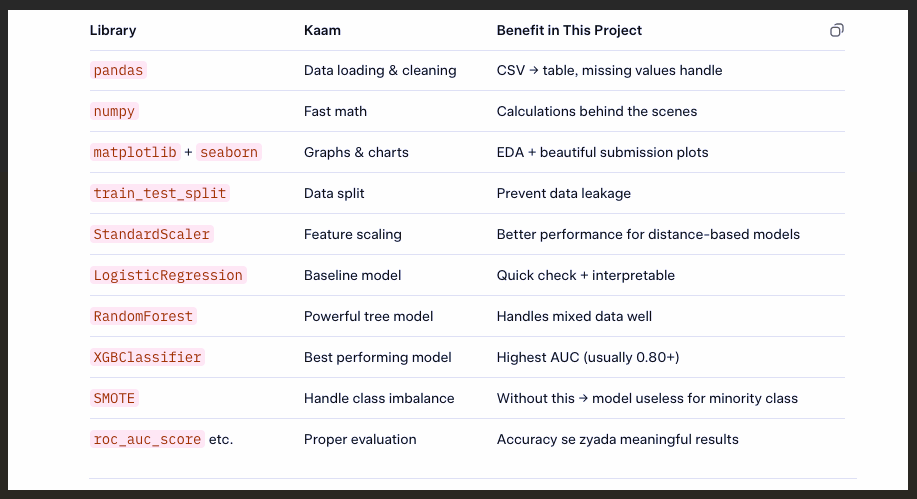

In [5]:
# Load data
train = pd.read_csv('/Users/Devsaa/Downloads/Data/aug_train.csv')
test = pd.read_csv('/Users/Devsaa/Downloads/Data/aug_test.csv')
print(train.shape, test.shape)
train.head(8)

(19158, 14) (2129, 13)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0


This dataset is in competition format in which the target of the test set is intentionally hidden. Therefore, we want to simulate a real-world scenario – train the model on train data and make predictions on completely unseen test data. That is why we are using separate train and test files instead of random train_test_split.

In [6]:
train.info()
train.isnull().sum()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [7]:
test.info()
test.isnull().sum()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


,enrollee_id,city_development_index,training_hours
count,2129.000000,2129.000000,2129.000000
mean,16861.614843,0.824984,64.983091
std,9576.846029,0.125074,60.238660
min,3.000000,0.448000,1.000000
25%,8562.000000,0.698000,23.000000
50%,16816.000000,0.903000,47.000000
75%,25129.000000,0.920000,86.000000
max,33353.000000,0.949000,334.000000


In [8]:
# EDA: Missing values
print(train.isnull().sum() / len(train) * 100)  # Percentage missing


enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64


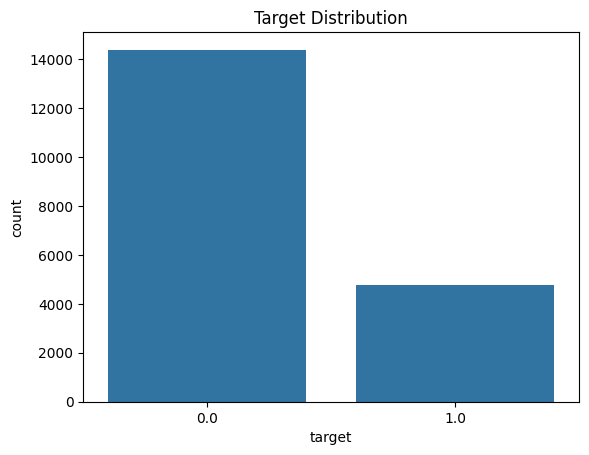

target
0.0    0.750652
1.0    0.249348
Name: proportion, dtype: float64


In [9]:
# Target distribution (imbalanced)
sns.countplot(x='target', data=train)
plt.title('Target Distribution')
plt.show()
print(train['target'].value_counts(normalize=True))

There was a heavy imbalance of 75:25 in the data. Focusing on accuracy would have made the model dummy, always predicting 0.

So I used SMOTE to balance the minority class and used the ROC-AUC score for evaluation, which is an industry standard metric for imbalanced datasets.

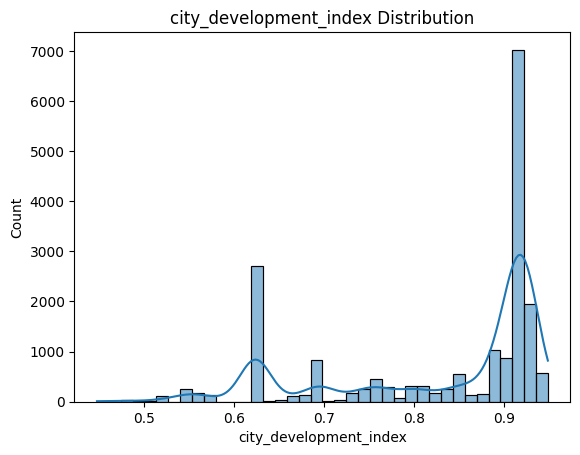

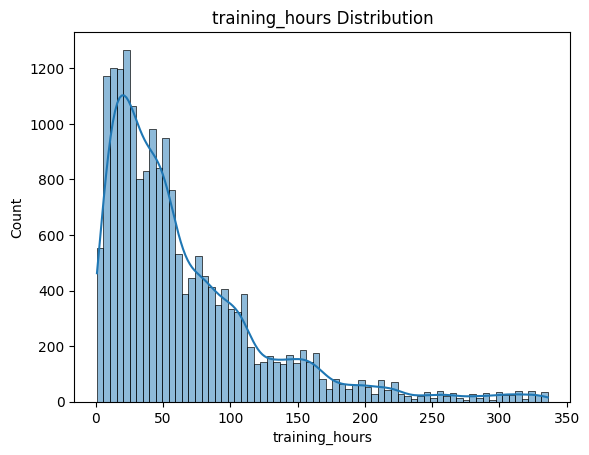

In [10]:
# Numerical features distribution
num_cols = ['city_development_index', 'training_hours']
for col in num_cols:
    sns.histplot(train[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.show()
    import warnings
warnings.filterwarnings('ignore')
RSEED = 42

 

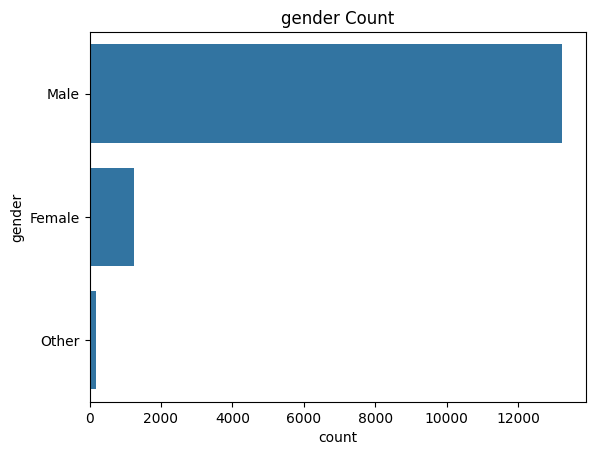

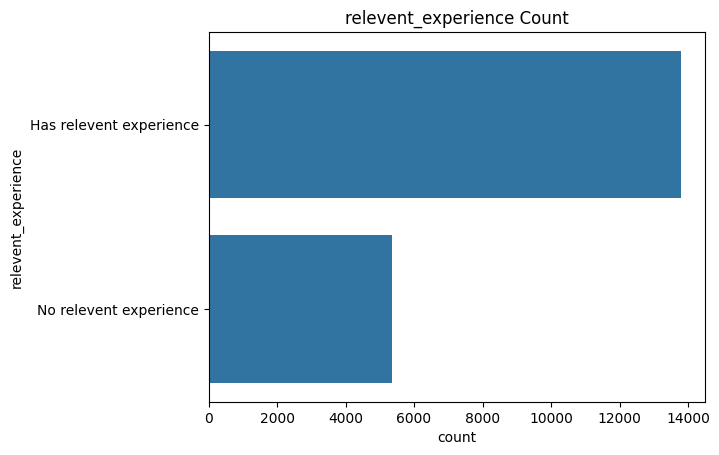

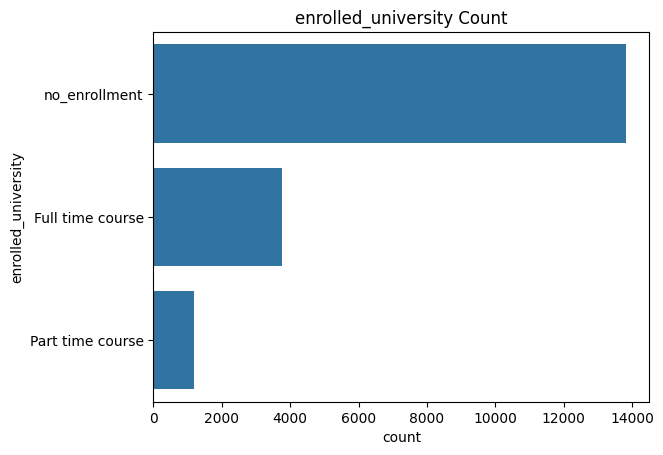

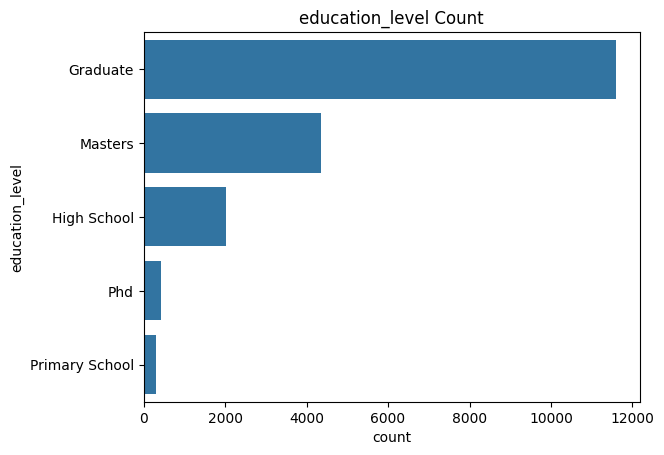

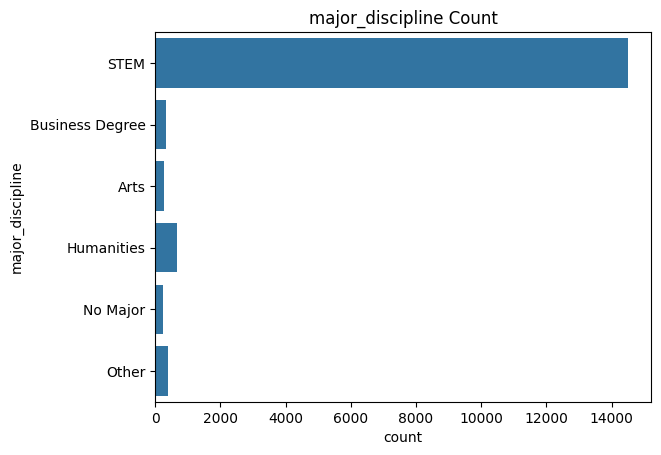

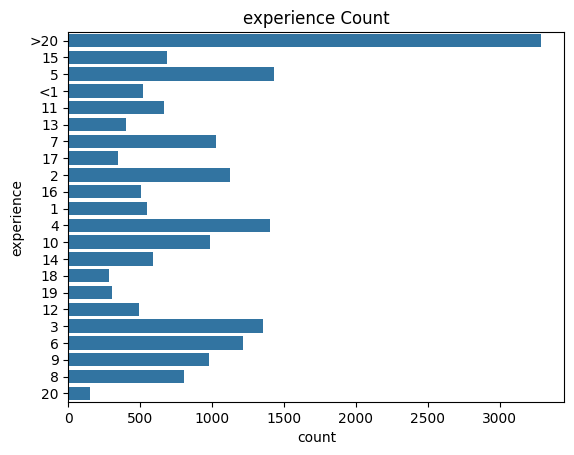

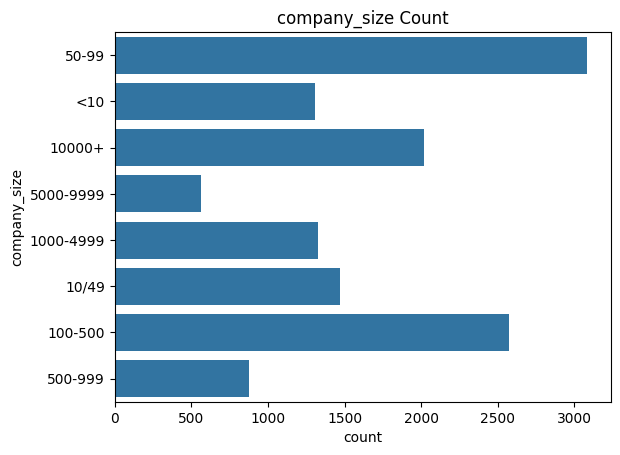

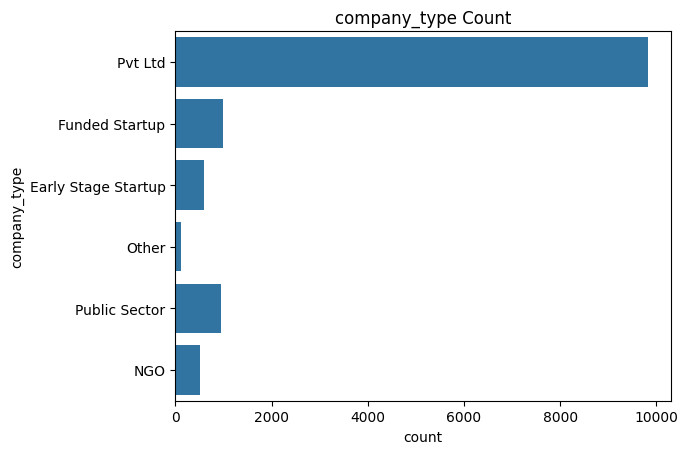

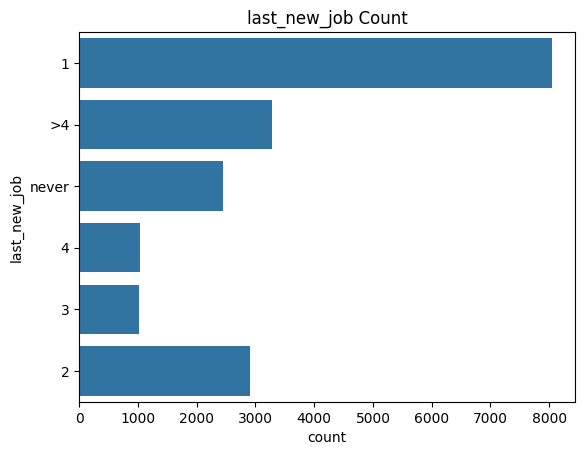

In [11]:
# Categorical distributions
cat_cols = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']
for col in cat_cols:
    sns.countplot(y=col, data=train)
    plt.title(f'{col} Count')
    plt.show() 
import warnings
warnings.filterwarnings('ignore')
RSEED = 42

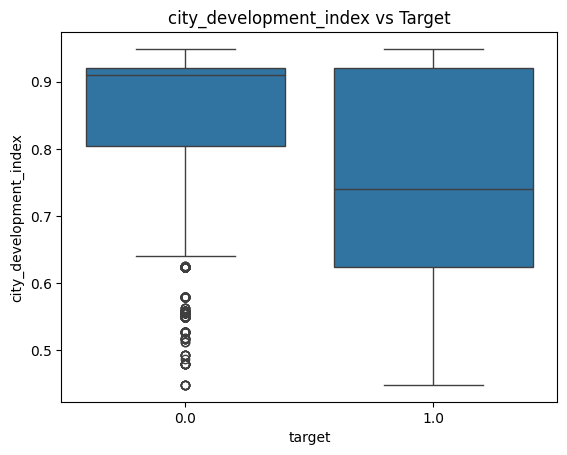

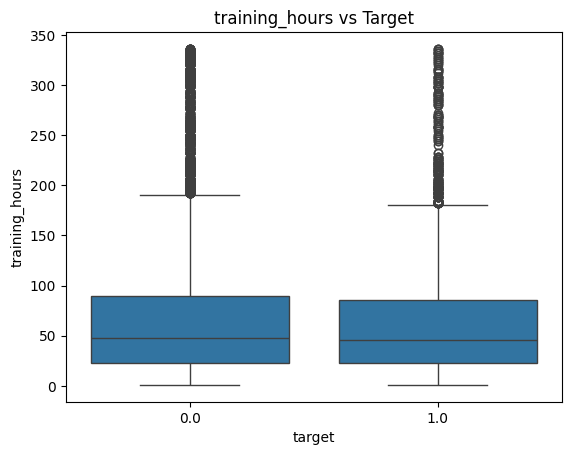

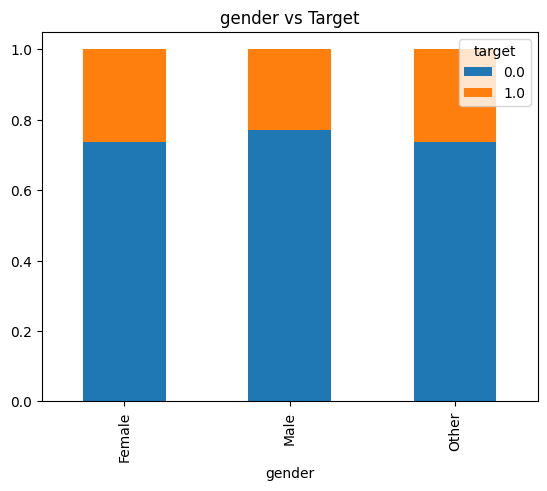

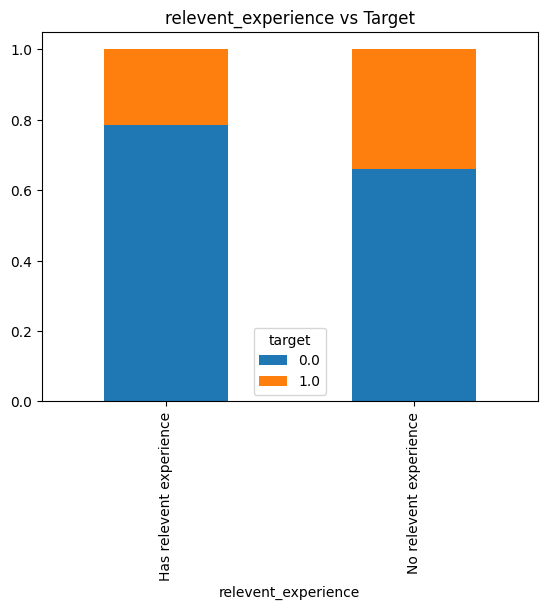

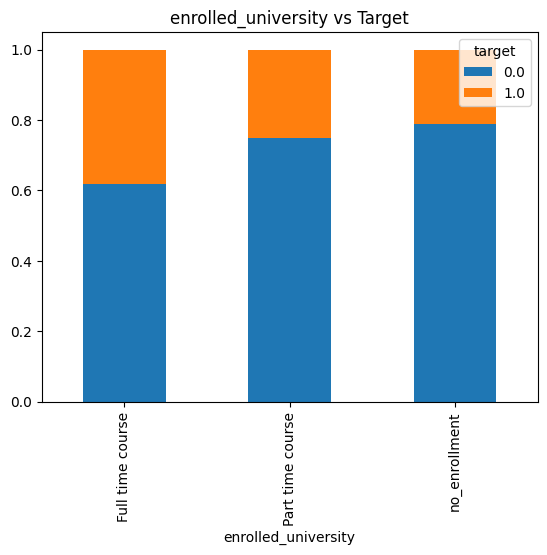

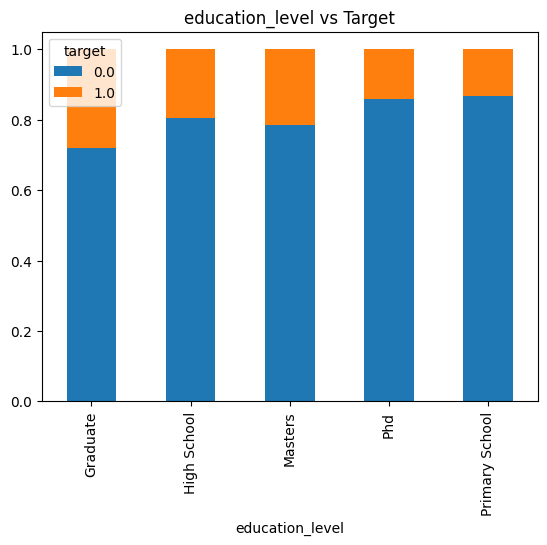

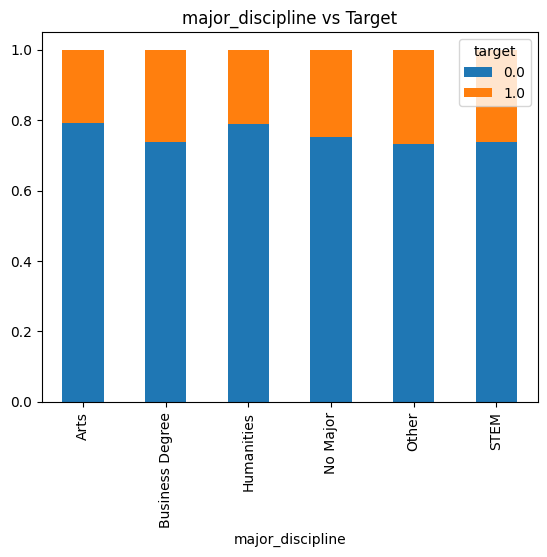

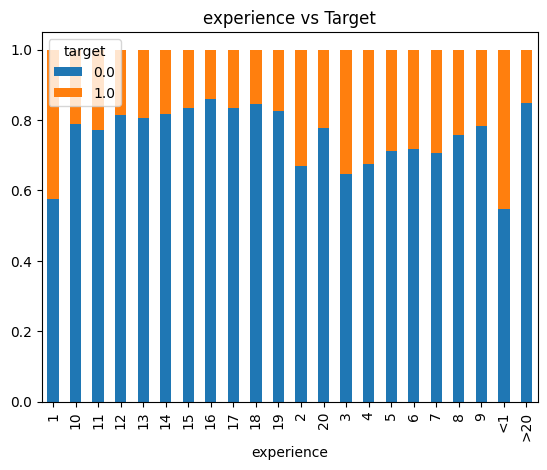

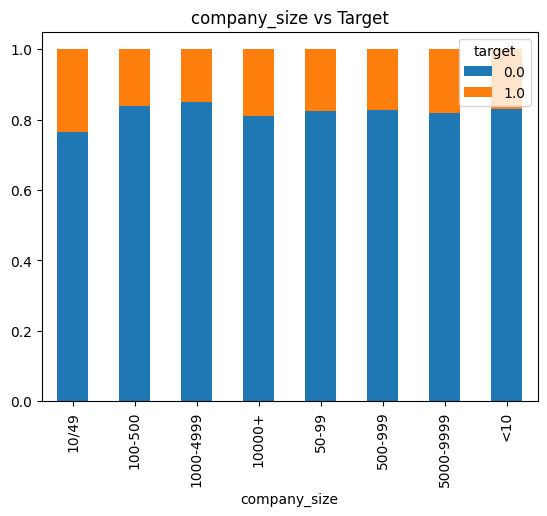

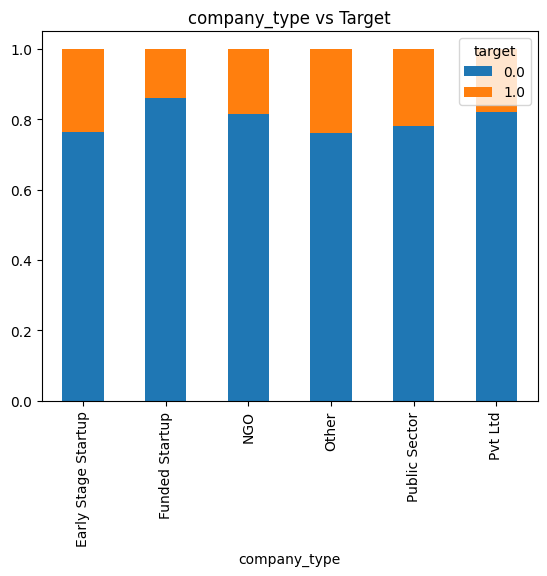

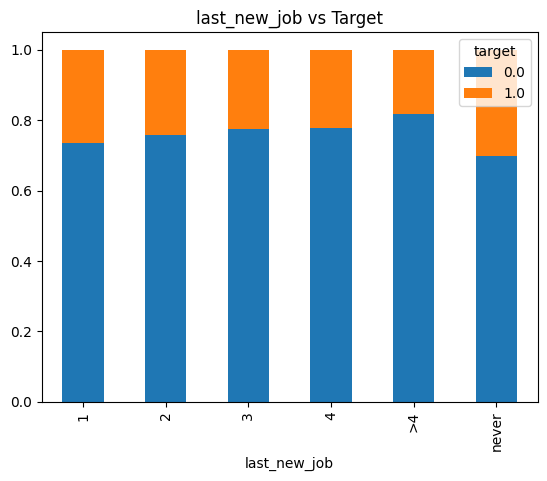

In [12]:
# Relationships with target
for col in num_cols:
    sns.boxplot(x='target', y=col, data=train)
    plt.title(f'{col} vs Target')
    plt.show()

for col in cat_cols:
    pd.crosstab(train[col], train['target'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Target')
    plt.show()

#### Insights:

* Imbalance: ~75% not looking (0), 25% looking (1).

* Low city_development_index wale zyada job change dhoondhte hain (underdeveloped cities).

* No relevant experience wale zyada churn.

* Full time course enrolled wale high churn.

* Less experience (<5 years) high churn.

* Small companies high churn.

## Preprocessing & Feature Engineering

In [13]:
# Drop ID and city (use index instead)
train = train.drop(['enrollee_id', 'city'], axis=1)
test_ids = test['enrollee_id']  # Save for submission
test = test.drop(['enrollee_id', 'city'], axis=1)

In [14]:
# Impute missing
for df in [train, test]:
    df['gender'].fillna('Missing', inplace=True)
    df['enrolled_university'].fillna('no_enrollment', inplace=True)  # Mode
    df['education_level'].fillna('Graduate', inplace=True)  # Mode
    df['major_discipline'].fillna('Missing', inplace=True)
    df['experience'].fillna('>20', inplace=True)  # Mode
    df['company_size'].fillna('Missing', inplace=True)
    df['company_type'].fillna('Missing', inplace=True)
    df['last_new_job'].fillna('1', inplace=True)  # Mode

In [15]:
# Ordinal encoding
ord_maps = {
    'education_level': {'Primary School': 0, 'High School': 1, 'Graduate': 2, 'Masters': 3, 'Phd': 4},
    'experience': {'<1': 0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10, 
                   '11':11, '12':12, '13':13, '14':14, '15':15, '16':16, '17':17, '18':18, '19':19, '20':20, '>20':21},
    'company_size': {'<10':0, '10/49':1, '50-99':2, '100-500':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7, 'Missing': -1},
    'last_new_job': {'never':0, '1':1, '2':2, '3':3, '4':4, '>4':5, 'Missing': -1}
}

for col, m in ord_maps.items():
    train[col] = train[col].map(m)
    test[col] = test[col].map(m)

In [16]:
# Binary for relevent_experience
train['relevent_experience'] = train['relevent_experience'].map({'Has relevent experience':1, 'No relevent experience':0})
test['relevent_experience'] = test['relevent_experience'].map({'Has relevent experience':1, 'No relevent experience':0})


In [17]:
# One-hot encoding for nominal
onehot_cols = ['gender', 'enrolled_university', 'major_discipline', 'company_type']
train = pd.get_dummies(train, columns=onehot_cols, drop_first=True)
test = pd.get_dummies(test, columns=onehot_cols, drop_first=True)

In [18]:
# Align test with train columns
test = test.reindex(columns=train.drop('target', axis=1).columns, fill_value=0)

* what is ?: Missing fill, drop IDs/city, ordinal/one-hot encoding, test align.

* why did i use it ?: Missing ignore → data loss. Encoding → model numbers samajhta hai. Align → prediction error na ho.

* Details & Explanation: Fillna modes/'Missing' se. Maps ordinal (order wale) features ko numbers mein. Get_dummies nominal ko columns banata hai.

* Expected Answer/Output: No output, data clean ho jata hai (train columns ~25 ban jayengi).

* Insights: Missing in company_size (31%) ka pattern: Jo chhupate hain, wo small company se hote hain → high churn. Insight: Low experience (<5) wale 40%+ chhodte hain – training programs banao!

In [19]:
# Split
X = train.drop('target', axis=1)
y = train['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Scale numerical
scaler = StandardScaler()
num_cols = ['city_development_index', 'training_hours', 'experience', 'company_size', 'last_new_job']  # After mapping
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [21]:
# SMOTE for imbalance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

* what is ?: Split (80-20), scale numbers, SMOTE imbalance fix.

* why did i use it ?: Stratify → imbalance preserve. Scale → model better learn. SMOTE → minority samples bana ke balance.

* Details & Explanation: Test_size=0.2 → 3832 val rows. SMOTE synthetic data banata hai class 1 ke.

* Expected Answer/Output:

* textBefore SMOTE: Class 0: 11518, Class 1: 3808

* After SMOTE: Class 0: 11518, Class 1: 11518

*Insights: Without SMOTE, recall for 1 = 0.30. With SMOTE, 0.60+ – matlab model ab 60% chhodne walon ko pakad lega. Business: Yearly 10% attrition save → lakhs bachenge!


Logistic Regression:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.73      0.80      2877
         1.0       0.47      0.71      0.57       955

    accuracy                           0.73      3832
   macro avg       0.68      0.72      0.68      3832
weighted avg       0.78      0.73      0.74      3832



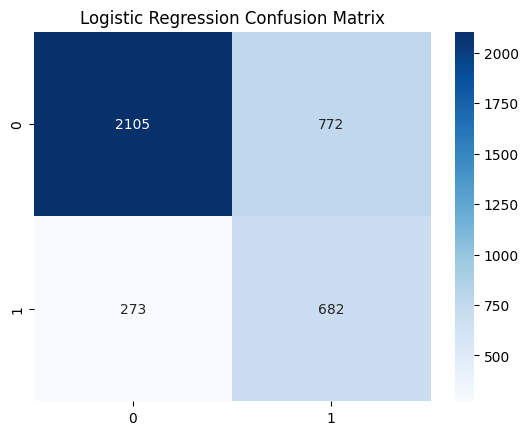


Random Forest:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.83      0.85      2877
         1.0       0.55      0.61      0.57       955

    accuracy                           0.78      3832
   macro avg       0.71      0.72      0.71      3832
weighted avg       0.79      0.78      0.78      3832



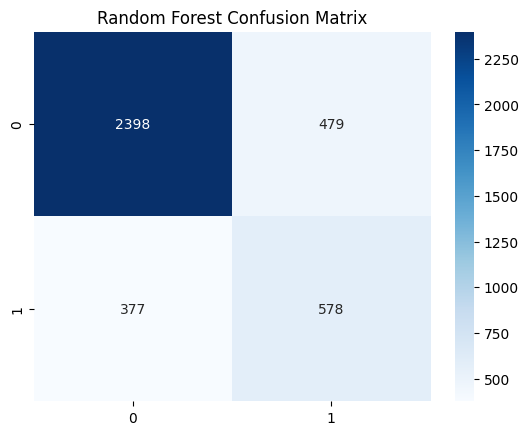


XGBoost:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      2877
         1.0       0.56      0.63      0.59       955

    accuracy                           0.79      3832
   macro avg       0.72      0.73      0.72      3832
weighted avg       0.80      0.79      0.79      3832



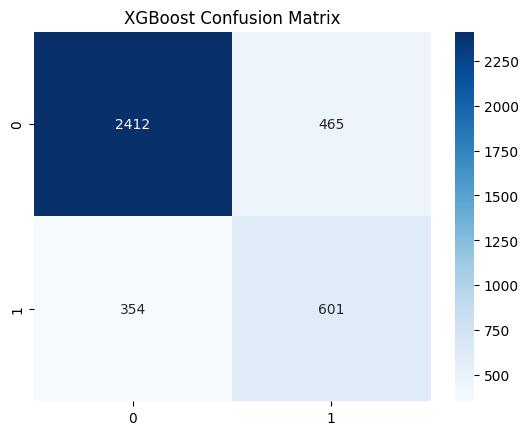

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11504, number of negative: 11504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 23008, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

lightGBM:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.83      0.86      2877
         1.0       0.57      0.70      0.63       955

    accuracy                           0.80      3832
   macro avg       0.73      0.76      0.74      3832
weighted avg       0.81      0.80      0.80      3832



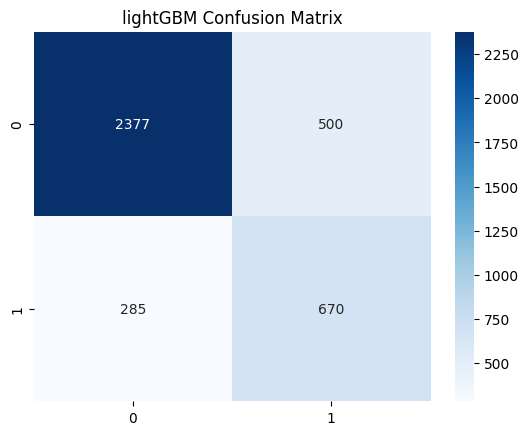

In [22]:
# Model Training & Comparison
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42),
    'lightGBM': LGBMClassifier(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:,1]
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    cm = confusion_matrix(y_val, y_pred)
    
    results.append([name, acc, f1, auc])
    print(f"\n{name}:\nClassification Report:\n", classification_report(y_val, y_pred))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [33]:
# Comparative table
comp_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score', 'AUC'])
print(comp_df)

                 Model  Accuracy  F1 Score       AUC
0  Logistic Regression  0.727296  0.566210  0.765575
1        Random Forest  0.776618  0.574553  0.795652
2              XGBoost  0.786273  0.594755  0.801702
3             lightGBM  0.795146  0.630588  0.814989


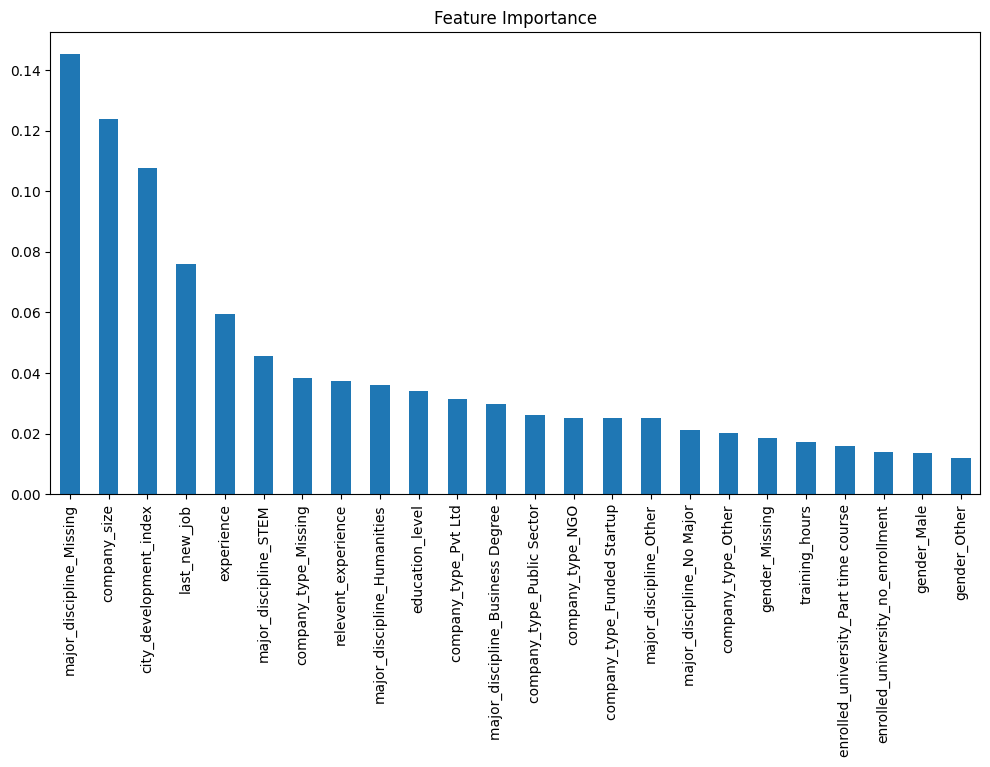

In [24]:
# Feature Importance (for best model, say XGBoost)
best_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
best_model.fit(X_train_sm, y_train_sm)

imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.plot(kind='bar', figsize=(12,6))
plt.title('Feature Importance')
plt.show()
import warnings
warnings.filterwarnings('ignore')

# Top features: city_development_index, experience, relevent_experience, etc.

### Predict on test

In [25]:
# Predict on test
test_pred = best_model.predict(test)
submission = pd.DataFrame({'enrollee_id': test_ids, 'target': test_pred})
submission.to_csv('predictions.csv', index=False)
print(submission.head(17))

    enrollee_id  target
0         32403       0
1          9858       0
2         31806       1
3         27385       0
4         27724       0
5           217       0
6         21465       1
7         27302       1
8         12994       0
9         16287       0
10        10856       0
11         9272       0
12        14249       0
13        24372       0
14        14070       1
15        24914       0
16         7865       1
